In [ ]:
!pip install ultralytics roboflow  matplotlib seaborn
!pip install --upgrade ultralytics


In [ ]:

# Import necessary libraries
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from roboflow import Roboflow
from ultralytics import RTDETR
from IPython.display import display, Image
import torch

# Setup plotting
plt.style.use('ggplot')
%matplotlib inline

# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

CUDA available: True
GPU device: Tesla T4


In [ ]:
# Download dataset from Roboflow
rf = Roboflow(api_key="E5BAeC0daBNvOy9YAGb2")
project = rf.workspace("sura").project("bike-helmet-detection-2vdjo-99amn")
version = project.version(1)
dataset = version.download("yolov8")

# Get dataset path and yaml file
data_yaml_path = os.path.join(dataset.location, "data.yaml")
print(f"Dataset downloaded to: {dataset.location}")
print(f"Data YAML path: {data_yaml_path}")

# Load and inspect the data.yaml file
with open(data_yaml_path, 'r') as file:
    data_config = yaml.safe_load(file)

print("\nDataset Configuration:")
print(f"Number of classes: {data_config['nc']}")
print(f"Class names: {data_config['names']}")
print(f"Train path: {data_config['train']}")
print(f"Validation path: {data_config['val']}")

loading Roboflow workspace...
loading Roboflow project...
Dataset downloaded to: /content/Bike-Helmet-Detection-1
Data YAML path: /content/Bike-Helmet-Detection-1/data.yaml

Dataset Configuration:
Number of classes: 2
Class names: ['With Helmet', 'Without Helmet']
Train path: ../train/images
Validation path: ../valid/images


In [ ]:
train_images = len(os.listdir(os.path.join(dataset.location, "train/images")))
val_images = len(os.listdir(os.path.join(dataset.location, "valid/images")))
test_images = len(os.listdir(os.path.join(dataset.location, "test/images"))) if os.path.exists(os.path.join(dataset.location, "test/images")) else 0

print(f"\nDataset Statistics:")
print(f"Training images: {train_images}")
print(f"Validation images: {val_images}")
print(f"Test images: {test_images}")
print(f"Total images: {train_images + val_images + test_images}")


Dataset Statistics:
Training images: 1185
Validation images: 127
Test images: 64
Total images: 1376


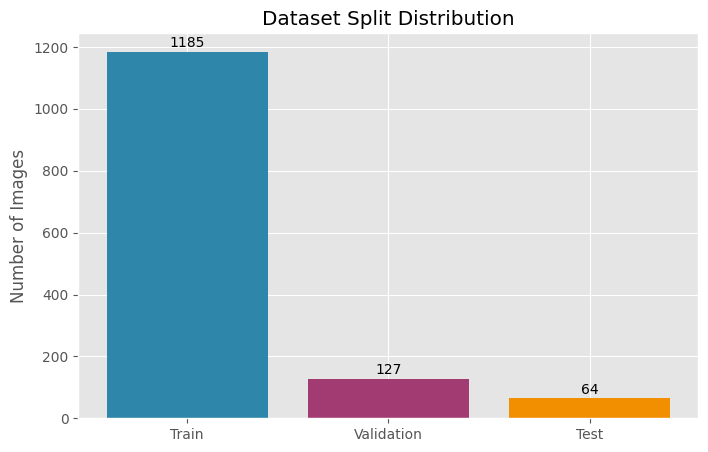

In [ ]:
# Visualize dataset distribution
plt.figure(figsize=(8, 5))
splits = ['Train', 'Validation', 'Test']
counts = [train_images, val_images, test_images]
plt.bar(splits, counts, color=['#2E86AB', '#A23B72', '#F18F01'])
plt.title('Dataset Split Distribution')
plt.ylabel('Number of Images')
for i, v in enumerate(counts):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')
plt.show()

In [ ]:
# Initialize RT-DETR model (using rtdetr-l for good balance of speed and accuracy)
model = RTDETR('rtdetr-l.pt')  # You can also use 'rtdetr-x.pt' for higher accuracy

print("RT-DETR model loaded successfully!")
print(f"Model: {model.model}")

RT-DETR model loaded successfully!
Model: DetectionModel(
  (model): Sequential(
    (0): HGStem(
      (stem1): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (stem2a): Conv(
        (conv): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (stem2b): Conv(
        (conv): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (stem3): Conv(
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine

In [ ]:

# Training parameters optimized for Colab
training_args = {
    'data': data_yaml_path,
    'epochs': 50,  # Reduced for faster training, increase to 100-150 for better results
    'imgsz': 640,
    'batch': 16,  # Adjust based on your GPU memory
    'lr0': 0.001,  # Learning rate
    'lrf': 0.01,   # Final learning rate
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,
    'box': 7.5,    # Box loss gain
    'cls': 0.5,    # Class loss gain
    'dfl': 1.5,    # DFL loss gain
    'patience': 100,  # Early stopping patience
    'save': True,
    'save_period': 10,  # Save checkpoint every 10 epochs
    'cache': False,  # Set to True if you have enough RAM
    'device': 0 if torch.cuda.is_available() else 'cpu',
    'workers': 8,
    'project': 'helmet_detection',
    'name': 'rtdetr_training',
    'exist_ok': True,
    'pretrained': True,
    'optimizer': 'AdamW',
    'verbose': True,
    'seed': 42,
    'deterministic': True,
    'single_cls': False,
    'rect': False,
    'cos_lr': True,  # Cosine learning rate scheduler
    'close_mosaic': 10,  # Disable mosaic augmentation for last 10 epochs
    'resume': False,
    'amp': True,  # Automatic Mixed Precision
    'fraction': 1.0,
    'profile': False,
    'overlap_mask': True,
    'mask_ratio': 4,
    'dropout': 0.0,
    'val': True,
}

print("Training configuration:")
for key, value in training_args.items():
    print(f"  {key}: {value}")

Training configuration:
  data: /content/Bike-Helmet-Detection-1/data.yaml
  epochs: 50
  imgsz: 640
  batch: 16
  lr0: 0.001
  lrf: 0.01
  momentum: 0.937
  weight_decay: 0.0005
  warmup_epochs: 3
  warmup_momentum: 0.8
  warmup_bias_lr: 0.1
  box: 7.5
  cls: 0.5
  dfl: 1.5
  patience: 100
  save: True
  save_period: 10
  cache: False
  device: 0
  workers: 8
  project: helmet_detection
  name: rtdetr_training
  exist_ok: True
  pretrained: True
  optimizer: AdamW
  verbose: True
  seed: 42
  deterministic: True
  single_cls: False
  rect: False
  cos_lr: True
  close_mosaic: 10
  resume: False
  amp: True
  fraction: 1.0
  profile: False
  overlap_mask: True
  mask_ratio: 4
  dropout: 0.0
  val: True


In [ ]:
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)

# Train the model
results = model.train(**training_args)

print("\nTraining completed!")


STARTING TRAINING
Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/Bike-Helmet-Detection-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=rtdetr-l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=rtdetr_training, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspecti

train: Scanning /content/Bike-Helmet-Detection-1/train/labels.cache... 1185 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1185/1185 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 371.5±360.2 MB/s, size: 27.7 KB)


val: Scanning /content/Bike-Helmet-Detection-1/valid/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]


Plotting labels to helmet_detection/rtdetr_training/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 143 weight(decay=0.0), 206 weight(decay=0.0005), 226 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to helmet_detection/rtdetr_training
Starting training for 50 epochs...

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
       1/50        13G       1.08      1.908      0.358          1        640: 100%|██████████| 75/75 [01:30<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        127        300     0.0278      0.219     0.0294     0.0129



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
       2/50      13.4G     0.5297      1.262     0.1322          8        640: 100%|██████████| 75/75 [01:28<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        127        300      0.532       0.33       0.12     0.0539



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
       3/50      13.2G     0.4186      1.274     0.1082          2        640: 100%|██████████| 75/75 [01:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        127        300      0.633      0.254      0.198      0.104



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
       4/50      13.2G     0.4143      1.161     0.1097          6        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        127        300      0.107      0.639      0.194      0.101



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
       5/50      13.4G     0.3888      1.041     0.1052          2        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.265      0.432      0.264      0.133



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
       6/50      13.6G     0.4267     0.8202     0.1167          2        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        127        300       0.51      0.582      0.509      0.266



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
       7/50      13.2G     0.4452     0.6826     0.1272          2        640: 100%|██████████| 75/75 [01:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        127        300       0.55      0.594      0.513      0.265



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
       8/50      13.2G     0.4348     0.6125     0.1233          4        640: 100%|██████████| 75/75 [01:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        127        300      0.665      0.534      0.513      0.251



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
       9/50      13.5G     0.4149     0.5716     0.1141          3        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        127        300      0.661       0.61      0.613      0.308



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      10/50      13.4G     0.3934     0.5386     0.1084         13        640: 100%|██████████| 75/75 [01:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        127        300      0.707      0.657       0.62      0.315



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      11/50      13.2G     0.3698     0.5345     0.1019          6        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.696      0.677      0.644      0.331



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      12/50      13.3G     0.3624     0.5596    0.09675          4        640: 100%|██████████| 75/75 [01:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        127        300      0.627      0.486      0.498      0.264



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      13/50      13.4G     0.3816     0.5608     0.1034          5        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        127        300      0.664       0.68      0.623      0.318



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      14/50      13.2G      0.375     0.5332     0.0983         13        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.701      0.661      0.645      0.344



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      15/50      13.2G     0.3624     0.5156     0.1001          3        640: 100%|██████████| 75/75 [01:27<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]

                   all        127        300      0.746       0.66      0.668      0.342



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      16/50        13G     0.3628     0.4906    0.09539          8        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        127        300      0.659      0.704      0.641      0.334



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      17/50      13.4G     0.3393     0.4756    0.08624         18        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        127        300      0.672      0.637      0.654      0.335



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      18/50      13.4G     0.3439     0.4996    0.09158          4        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        127        300      0.679      0.695      0.627      0.318



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      19/50      13.2G     0.3261     0.4679    0.08674          2        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]

                   all        127        300      0.747      0.638      0.653      0.333



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      20/50      13.3G     0.3208     0.4641     0.0833          6        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        127        300       0.76      0.635      0.641      0.344



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      21/50      13.5G     0.3198       0.46    0.07903          3        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.731      0.687      0.676      0.352



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      22/50      13.4G     0.3014     0.4492    0.07838          1        640: 100%|██████████| 75/75 [01:23<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

                   all        127        300      0.714      0.626      0.637      0.333



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      23/50      13.4G     0.3081     0.4435    0.08075          2        640: 100%|██████████| 75/75 [01:23<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]

                   all        127        300      0.787      0.649      0.657      0.358



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      24/50      13.2G     0.3112       0.46    0.08092         20        640: 100%|██████████| 75/75 [01:23<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        127        300      0.755      0.641      0.678       0.36



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      25/50      13.5G      0.295     0.4282    0.07813          4        640: 100%|██████████| 75/75 [01:24<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        127        300      0.713      0.684      0.638      0.336



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      26/50      13.6G     0.2946     0.4208    0.07824          1        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        127        300      0.682      0.659      0.643      0.351



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      27/50      13.1G     0.2906     0.4145    0.07302          1        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        127        300      0.768      0.607      0.651      0.348



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      28/50      13.2G     0.2865     0.4023    0.07441          3        640: 100%|██████████| 75/75 [01:27<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        127        300      0.777      0.674      0.692      0.366



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      29/50      13.7G      0.282     0.4087    0.07075          5        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.715      0.711      0.678      0.359



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      30/50      13.6G      0.264     0.3892     0.0667          1        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.696      0.699      0.673      0.361



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      31/50      13.4G     0.2682     0.3956    0.06864          7        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        127        300      0.723      0.668      0.654      0.346



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      32/50        13G     0.2657     0.3917    0.06464          2        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.773      0.576      0.609      0.319



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      33/50      13.4G     0.2612     0.3832    0.06763          1        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        127        300       0.72      0.711       0.69       0.36



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      34/50      13.5G     0.2687     0.3864    0.06519         13        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]

                   all        127        300      0.739      0.698        0.7      0.366



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      35/50      13.2G     0.2448      0.361    0.06217          3        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.789      0.676      0.704       0.38



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      36/50      13.1G     0.2487     0.3618    0.06288          7        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        127        300      0.754      0.668      0.681      0.366



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      37/50      13.2G     0.2452     0.3528    0.05911          1        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]

                   all        127        300      0.719      0.646      0.651      0.354



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      38/50      13.4G     0.2306     0.3445    0.05676          3        640: 100%|██████████| 75/75 [01:25<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]

                   all        127        300       0.74      0.666      0.664      0.358



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      39/50      13.2G     0.2344     0.3385    0.06031          5        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.759      0.694      0.694      0.372



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      40/50        13G     0.2298     0.3353    0.05768          2        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]

                   all        127        300      0.764      0.641      0.675      0.359


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      41/50      13.5G     0.2005     0.3101    0.05527          1        640: 100%|██████████| 75/75 [01:27<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        127        300      0.781      0.632      0.673      0.351



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      42/50      13.4G     0.1963     0.3093    0.05577          3        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        127        300      0.758      0.679      0.682      0.362



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      43/50      13.2G      0.191      0.308    0.05427         11        640: 100%|██████████| 75/75 [01:25<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.813      0.623      0.683      0.362



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      44/50      13.1G     0.1925     0.2867    0.05594          1        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        127        300      0.819      0.633      0.683      0.362



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      45/50      13.4G     0.1886     0.2907    0.05223          2        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]

                   all        127        300      0.828      0.634      0.688      0.365



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      46/50      13.4G     0.1824     0.2876    0.05057          1        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.827      0.639      0.688      0.363



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      47/50      13.4G     0.1797     0.2834    0.04928          1        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.834      0.633      0.685      0.368



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      48/50      13.1G     0.1823     0.2795    0.04922          5        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]

                   all        127        300      0.829      0.633      0.688       0.37



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      49/50      13.5G     0.1779     0.2817     0.0489          2        640: 100%|██████████| 75/75 [01:26<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all        127        300      0.823      0.625      0.685      0.369



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


  0%|          | 0/75 [00:00<?, ?it/s]grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:92.)
      50/50      13.4G      0.178     0.2802    0.04944          1        640: 100%|██████████| 75/75 [01:26<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        127        300      0.825       0.63      0.682      0.365



50 epochs completed in 1.462 hours.
Optimizer stripped from helmet_detection/rtdetr_training/weights/last.pt, 66.1MB
Optimizer stripped from helmet_detection/rtdetr_training/weights/best.pt, 66.1MB

Validating helmet_detection/rtdetr_training/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


                   all        127        300       0.79      0.676      0.704       0.38
           With Helmet         89        185      0.855      0.849       0.85      0.489
        Without Helmet         53        115      0.724      0.503      0.557      0.272
Speed: 0.3ms preprocess, 17.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to helmet_detection/rtdetr_training

Training completed!


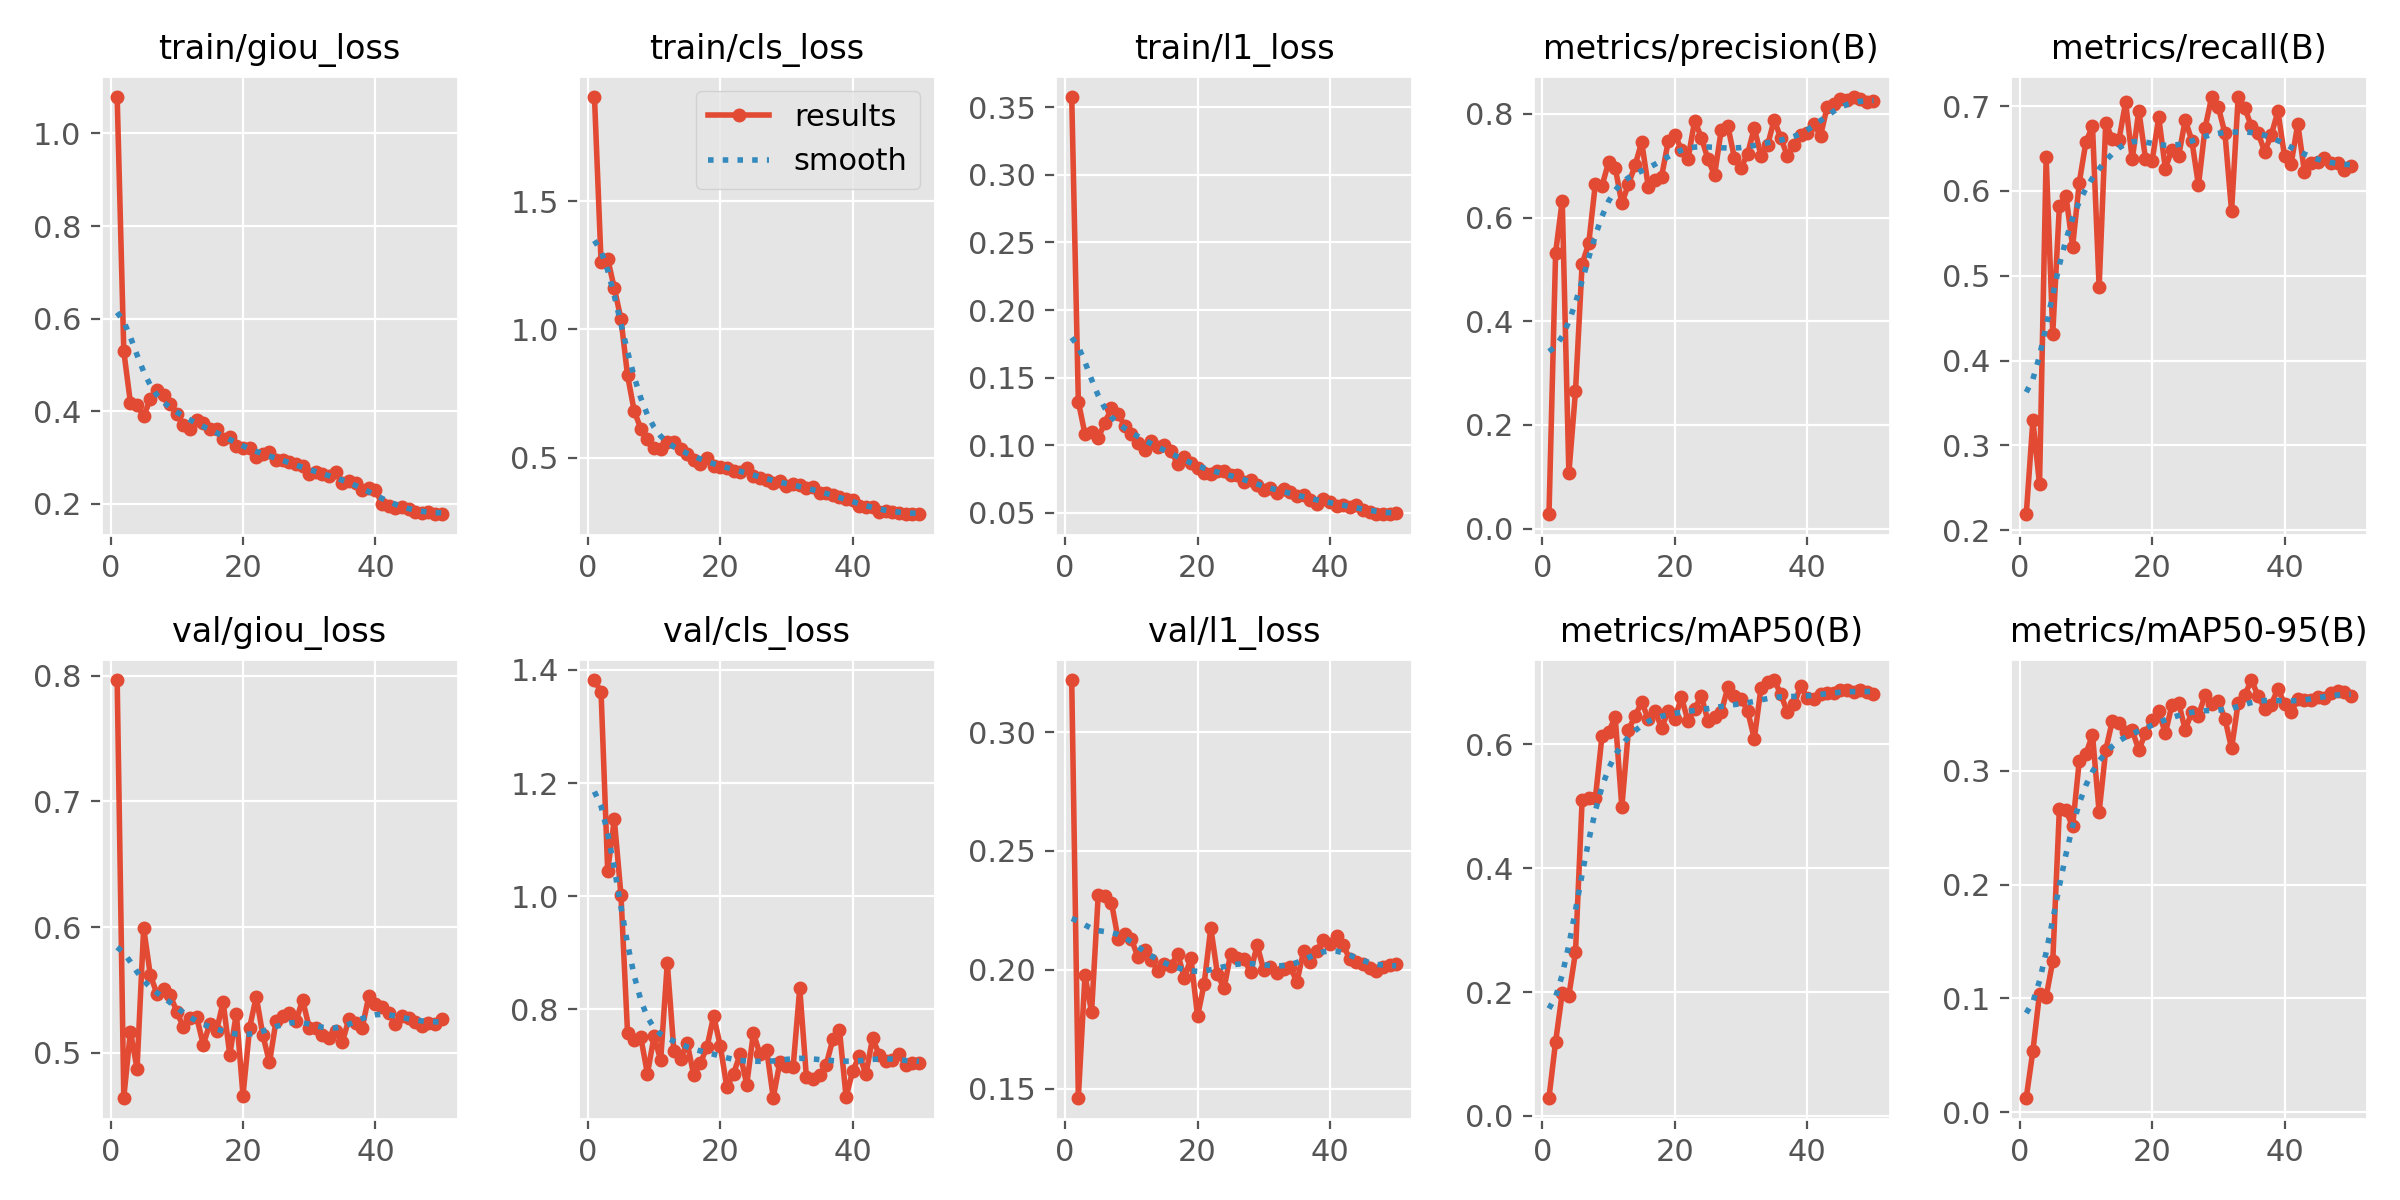

KeyError: 'train/box_loss'

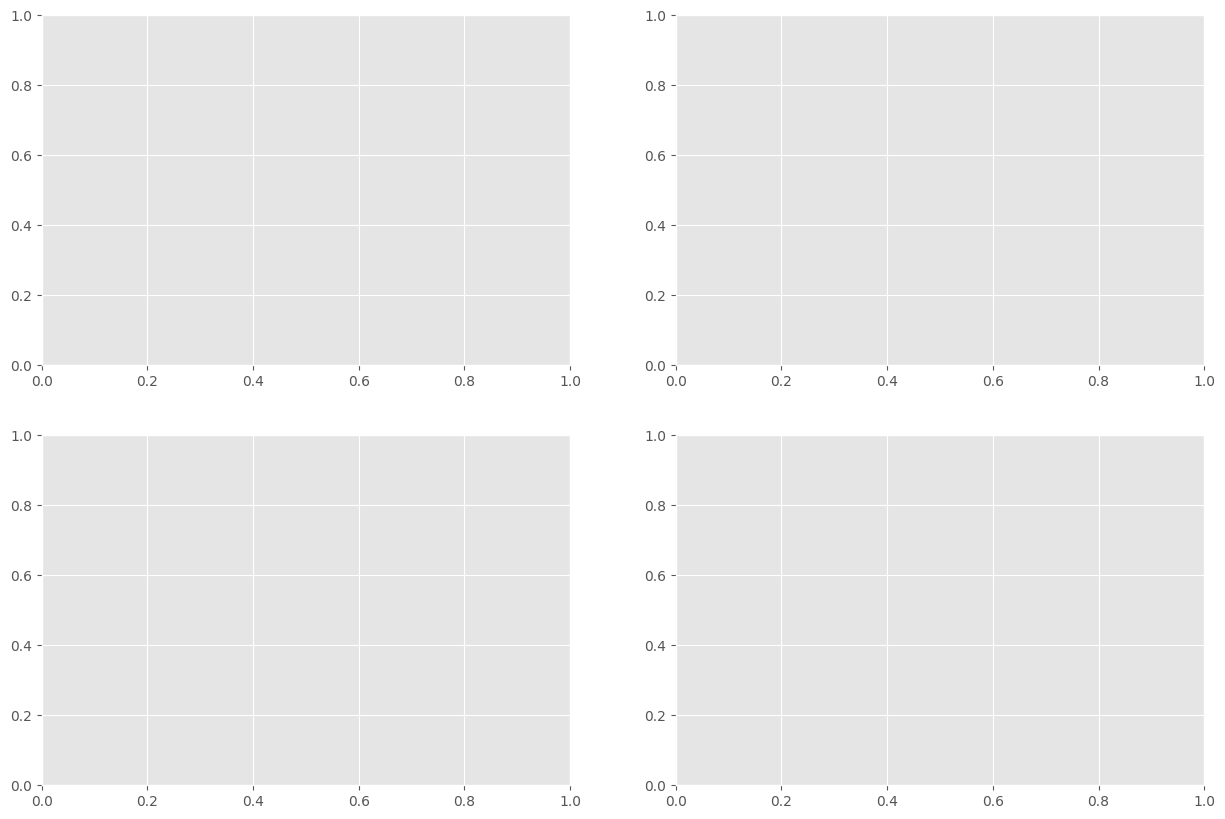

In [ ]:
# Plot training results
results_dir = f"helmet_detection/rtdetr_training"
if os.path.exists(f"{results_dir}/results.png"):
    display(Image(f"{results_dir}/results.png"))

# Load and display metrics
if os.path.exists(f"{results_dir}/results.csv"):
    import pandas as pd
    metrics_df = pd.read_csv(f"{results_dir}/results.csv")

    # Plot training metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss plots
    axes[0,0].plot(metrics_df['epoch'], metrics_df['train/box_loss'], label='Train Box Loss')
    axes[0,0].plot(metrics_df['epoch'], metrics_df['val/box_loss'], label='Val Box Loss')
    axes[0,0].set_title('Box Loss')
    axes[0,0].legend()

    axes[0,1].plot(metrics_df['epoch'], metrics_df['train/cls_loss'], label='Train Class Loss')
    axes[0,1].plot(metrics_df['epoch'], metrics_df['val/cls_loss'], label='Val Class Loss')
    axes[0,1].set_title('Classification Loss')
    axes[0,1].legend()

    # Metrics plots
    axes[1,0].plot(metrics_df['epoch'], metrics_df['metrics/precision(B)'], label='Precision')
    axes[1,0].plot(metrics_df['epoch'], metrics_df['metrics/recall(B)'], label='Recall')
    axes[1,0].set_title('Precision & Recall')
    axes[1,0].legend()

    axes[1,1].plot(metrics_df['epoch'], metrics_df['metrics/mAP50(B)'], label='mAP@0.5')
    axes[1,1].plot(metrics_df['epoch'], metrics_df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
    axes[1,1].set_title('mAP Scores')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
print("\n" + "="*50)
print("RUNNING VALIDATION")
print("="*50)

# Load the best trained model
best_model = RTDETR(f"{results_dir}/weights/best.pt")

# Validate the model
val_results = best_model.val(data=data_yaml_path, imgsz=640, batch=16)

print(f"\nValidation Results:")
print(f"mAP@0.5: {val_results.box.map50:.4f}")
print(f"mAP@0.5:0.95: {val_results.box.map:.4f}")
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")


RUNNING VALIDATION
Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1031.0±348.1 MB/s, size: 30.8 KB)


val: Scanning /content/Bike-Helmet-Detection-1/valid/labels.cache... 127 images, 0 backgrounds, 0 corrupt: 100%|██████████| 127/127 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


                   all        127        300       0.79      0.676      0.704      0.379
           With Helmet         89        185      0.856      0.849      0.851      0.487
        Without Helmet         53        115      0.724      0.503      0.557      0.271
Speed: 4.0ms preprocess, 36.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val

Validation Results:
mAP@0.5: 0.7037
mAP@0.5:0.95: 0.3792
Precision: 0.7900
Recall: 0.6759


In [ ]:
print("\n" + "="*50)
print("TESTING PREDICTIONS")
print("="*50)

# Test on validation images
val_image_dir = os.path.join(dataset.location, "valid/images")
test_images = os.listdir(val_image_dir)[:5]  # Test on first 5 images

for img_name in test_images:
    img_path = os.path.join(val_image_dir, img_name)

    # Run prediction
    results = best_model.predict(img_path, conf=0.5, save=True, save_txt=True)

    # Display results
    for r in results:
        print(f"\nPredictions for {img_name}:")
        if len(r.boxes) > 0:
            for i, box in enumerate(r.boxes):
                cls = int(box.cls)
                conf = float(box.conf)
                print(f"  Detection {i+1}: {data_config['names'][cls]} (confidence: {conf:.3f})")
        else:
            print("  No detections found")



TESTING PREDICTIONS

image 1/1 /content/Bike-Helmet-Detection-1/valid/images/BikesHelmets759_png_jpg.rf.8efd5ea9699433734b22e4e243f916d5.jpg: 640x640 1 With Helmet, 2 Without Helmets, 98.5ms
Speed: 4.8ms preprocess, 98.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels

Predictions for BikesHelmets759_png_jpg.rf.8efd5ea9699433734b22e4e243f916d5.jpg:
  Detection 1: With Helmet (confidence: 0.854)
  Detection 2: Without Helmet (confidence: 0.865)
  Detection 3: Without Helmet (confidence: 0.616)

image 1/1 /content/Bike-Helmet-Detection-1/valid/images/BikesHelmets720_png_jpg.rf.a3805a46951dc7664d9dcbd7185b886a.jpg: 640x640 2 With Helmets, 84.7ms
Speed: 4.5ms preprocess, 84.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
2 labels saved to runs/detect/predict/labels

Predictions for BikesHelmets720_png_jpg.rf.a3805a46951dc7664d9dcbd71

In [ ]:
print("\n" + "="*50)
print("EXPORTING MODEL")
print("="*50)

# Export to different formats
export_formats = ['onnx', 'torchscript']

for format_type in export_formats:
    try:
        exported_model = best_model.export(format=format_type, imgsz=640)
        print(f"Model exported to {format_type.upper()}: {exported_model}")
    except Exception as e:
        print(f"Error exporting to {format_type}: {e}")



EXPORTING MODEL
Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
rt-detr-l summary: 302 layers, 31,987,850 parameters, 0 gradients, 103.4 GFLOPs

PyTorch: starting from 'helmet_detection/rtdetr_training/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (63.1 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.56', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 22.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.57...
ONNX: export success ✅ 71.3s, saved as 'helmet_detection/rtdetr_training/weights/best.onnx' (122.9 MB)

Export complete (76.8s)
Results saved to /content/helmet_detection/

In [ ]:
print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)

summary = {
    'Dataset': 'Bike Helmet Detection',
    'Model': 'RT-DETR-L',
    'Training Images': train_images,
    'Validation Images': val_images,
    'Classes': data_config['names'],
    'Epochs Trained': training_args['epochs'],
    'Best mAP@0.5': f"{val_results.box.map50:.4f}",
    'Best mAP@0.5:0.95': f"{val_results.box.map:.4f}",
    'Model Path': f"{results_dir}/weights/best.pt",
}

print("\nFinal Results:")
for key, value in summary.items():
    print(f"  {key}: {value}")

print(f"\nBest model saved at: {results_dir}/weights/best.pt")
print(f"Training logs saved at: {results_dir}/")
print("\nTraining completed successfully! 🎉")


TRAINING SUMMARY

Final Results:
  Dataset: Bike Helmet Detection
  Model: RT-DETR-L
  Training Images: 1185
  Validation Images: 127
  Classes: ['With Helmet', 'Without Helmet']
  Epochs Trained: 50
  Best mAP@0.5: 0.7037
  Best mAP@0.5:0.95: 0.3792
  Model Path: helmet_detection/rtdetr_training/weights/best.pt

Best model saved at: helmet_detection/rtdetr_training/weights/best.pt
Training logs saved at: helmet_detection/rtdetr_training/

Training completed successfully! 🎉


In [ ]:
# ===================================
# RT-DETR VIDEO INFERENCE PIPELINE
# ===================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import RTDETR
from IPython.display import HTML, display, Video
from google.colab import files
import time

# ===================================
# STEP 1: UPLOAD YOUR VIDEO
# ===================================

print("📹 UPLOAD YOUR VIDEO FILE")
print("=" * 40)

# Upload video file
uploaded = files.upload()

# Get the uploaded video filename
video_filename = list(uploaded.keys())[0]
print(f"✅ Uploaded: {video_filename}")

# Verify video file
if not os.path.exists(video_filename):
    print("❌ Video file not found!")
    exit()

# Get video info
cap = cv2.VideoCapture(video_filename)
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
duration = frame_count / fps

print(f"\n📊 Video Information:")
print(f"  • Resolution: {width}x{height}")
print(f"  • FPS: {fps}")
print(f"  • Duration: {duration:.2f} seconds")
print(f"  • Total Frames: {frame_count}")

cap.release()

# ===================================
# STEP 2: LOAD YOUR TRAINED MODEL
# ===================================

print("\n🤖 LOADING YOUR TRAINED MODEL")
print("=" * 40)

# Load your trained RT-DETR model
# Replace 'path/to/your/best.pt' with your actual model path
model_path = "helmet_detection/rtdetr_training/weights/best.pt"  # Update this path

try:
    model = RTDETR(model_path)
    print(f"✅ Model loaded successfully from: {model_path}")
    print(f"  • Model classes: {list(model.names.values())}")
    print(f"  • Number of classes: {len(model.names)}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Please update the model_path variable with your correct model path")
    # Fallback to upload model file
    print("\n📁 Please upload your best.pt model file:")
    model_upload = files.upload()
    model_filename = list(model_upload.keys())[0]
    model = RTDETR(model_filename)
    print(f"✅ Model loaded from uploaded file: {model_filename}")

# ===================================
# STEP 3: CONFIGURATION SETTINGS
# ===================================

print("\n⚙️ INFERENCE CONFIGURATION")
print("=" * 40)

# Inference settings
CONFIDENCE_THRESHOLD = 0.5  # Adjust as needed (0.1 - 0.9)
IOU_THRESHOLD = 0.45       # Non-max suppression threshold
MAX_DETECTIONS = 300       # Maximum detections per frame
SAVE_RESULTS = True        # Save output video
SHOW_LABELS = True         # Show class labels
SHOW_CONFIDENCE = True     # Show confidence scores
LINE_THICKNESS = 2         # Bounding box thickness

print(f"  • Confidence Threshold: {CONFIDENCE_THRESHOLD}")
print(f"  • IOU Threshold: {IOU_THRESHOLD}")
print(f"  • Max Detections: {MAX_DETECTIONS}")
print(f"  • Save Results: {SAVE_RESULTS}")

# ===================================
# STEP 4: VIDEO PROCESSING FUNCTION
# ===================================

def process_video_with_rtdetr(input_video, output_video, model, conf_threshold=0.5):
    """Process video with RT-DETR model and save results"""

    # Open input video
    cap = cv2.VideoCapture(input_video)

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Setup video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    # Processing statistics
    detection_stats = {
        'total_frames': 0,
        'frames_with_detections': 0,
        'total_detections': 0,
        'class_counts': {},
        'processing_times': []
    }

    print(f"\n🎬 Processing {total_frames} frames...")

    frame_num = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_num += 1
        start_time = time.time()

        # Run inference
        results = model.predict(
            frame,
            conf=conf_threshold,
            iou=IOU_THRESHOLD,
            max_det=MAX_DETECTIONS,
            verbose=False
        )

        processing_time = time.time() - start_time
        detection_stats['processing_times'].append(processing_time)
        detection_stats['total_frames'] += 1

        # Process results
        if len(results) > 0 and len(results[0].boxes) > 0:
            detection_stats['frames_with_detections'] += 1

            # Get detections
            boxes = results[0].boxes
            detection_stats['total_detections'] += len(boxes)

            # Draw detections
            for box in boxes:
                # Get box coordinates
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
                confidence = float(box.conf[0])
                class_id = int(box.cls[0])
                class_name = model.names[class_id]

                # Update class counts
                if class_name not in detection_stats['class_counts']:
                    detection_stats['class_counts'][class_name] = 0
                detection_stats['class_counts'][class_name] += 1

                # Choose color based on class
                colors = {
                    'helmet': (0, 255, 0),      # Green for helmet
                    'no-helmet': (0, 0, 255),  # Red for no helmet
                    'head': (255, 0, 0),       # Blue for head
                }
                color = colors.get(class_name.lower(), (255, 255, 0))  # Yellow default

                # Draw bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, LINE_THICKNESS)

                # Draw label
                if SHOW_LABELS:
                    label = f"{class_name}"
                    if SHOW_CONFIDENCE:
                        label += f" {confidence:.2f}"

                    # Get text size
                    (text_width, text_height), _ = cv2.getTextSize(
                        label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2
                    )

                    # Draw label background
                    cv2.rectangle(
                        frame,
                        (x1, y1 - text_height - 10),
                        (x1 + text_width, y1),
                        color,
                        -1
                    )

                    # Draw label text
                    cv2.putText(
                        frame,
                        label,
                        (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.6,
                        (255, 255, 255),
                        2
                    )

        # Add frame info
        info_text = f"Frame: {frame_num}/{total_frames} | FPS: {1/processing_time:.1f}"
        cv2.putText(frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        # Write frame
        out.write(frame)

        # Progress update
        if frame_num % 30 == 0:
            progress = (frame_num / total_frames) * 100
            avg_fps = 1 / np.mean(detection_stats['processing_times'][-30:])
            print(f"  Progress: {progress:.1f}% | Avg FPS: {avg_fps:.1f}")

    # Cleanup
    cap.release()
    out.release()

    return detection_stats

# ===================================
# STEP 5: PROCESS THE VIDEO
# ===================================

print("\n🚀 STARTING VIDEO PROCESSING")
print("=" * 40)

# Set output filename
output_filename = f"output_{video_filename}"

# Process the video
stats = process_video_with_rtdetr(
    video_filename,
    output_filename,
    model,
    CONFIDENCE_THRESHOLD
)

print("\n✅ Video processing completed!")

# ===================================
# STEP 6: DISPLAY RESULTS & STATISTICS
# ===================================

print("\n📊 PROCESSING STATISTICS")
print("=" * 40)

# Calculate statistics
avg_processing_time = np.mean(stats['processing_times'])
avg_fps = 1 / avg_processing_time
detection_rate = (stats['frames_with_detections'] / stats['total_frames']) * 100

print(f"  • Total Frames Processed: {stats['total_frames']}")
print(f"  • Frames with Detections: {stats['frames_with_detections']}")
print(f"  • Detection Rate: {detection_rate:.1f}%")
print(f"  • Total Detections: {stats['total_detections']}")
print(f"  • Average Processing FPS: {avg_fps:.1f}")
print(f"  • Average Processing Time: {avg_processing_time*1000:.1f}ms per frame")

if stats['class_counts']:
    print(f"\n🎯 Detection Breakdown:")
    for class_name, count in stats['class_counts'].items():
        print(f"  • {class_name}: {count} detections")

# ===================================
# STEP 7: VISUALIZE STATISTICS
# ===================================

if stats['class_counts']:
    # Plot detection statistics
    plt.figure(figsize=(12, 8))

    # Class distribution
    plt.subplot(2, 2, 1)
    classes = list(stats['class_counts'].keys())
    counts = list(stats['class_counts'].values())
    colors = ['green' if 'helmet' in c.lower() else 'red' for c in classes]
    plt.bar(classes, counts, color=colors, alpha=0.7)
    plt.title('Detection Count by Class')
    plt.ylabel('Number of Detections')
    plt.xticks(rotation=45)

    # Processing time over frames
    plt.subplot(2, 2, 2)
    frame_numbers = range(1, len(stats['processing_times']) + 1)
    plt.plot(frame_numbers, stats['processing_times'], alpha=0.7)
    plt.title('Processing Time per Frame')
    plt.xlabel('Frame Number')
    plt.ylabel('Processing Time (seconds)')

    # FPS over time
    plt.subplot(2, 2, 3)
    fps_values = [1/t for t in stats['processing_times']]
    plt.plot(frame_numbers, fps_values, color='orange', alpha=0.7)
    plt.title('Processing FPS over Time')
    plt.xlabel('Frame Number')
    plt.ylabel('FPS')

    # Summary pie chart
    plt.subplot(2, 2, 4)
    detection_labels = ['Frames with Detections', 'Frames without Detections']
    detection_values = [stats['frames_with_detections'],
                       stats['total_frames'] - stats['frames_with_detections']]
    plt.pie(detection_values, labels=detection_labels, autopct='%1.1f%%',
            colors=['lightgreen', 'lightcoral'])
    plt.title('Detection Coverage')

    plt.tight_layout()
    plt.show()

# ===================================
# STEP 8: DOWNLOAD RESULTS
# ===================================

print("\n💾 DOWNLOADING RESULTS")
print("=" * 40)

# Download the processed video
if os.path.exists(output_filename):
    print(f"⬇️ Downloading processed video: {output_filename}")
    files.download(output_filename)
    print("✅ Video download completed!")
else:
    print("❌ Output video not found!")

# Create and download summary report
report_filename = f"detection_report_{video_filename.split('.')[0]}.txt"
with open(report_filename, 'w') as f:
    f.write("RT-DETR HELMET DETECTION REPORT\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Video File: {video_filename}\n")
    f.write(f"Model: RT-DETR\n")
    f.write(f"Confidence Threshold: {CONFIDENCE_THRESHOLD}\n\n")
    f.write("STATISTICS:\n")
    f.write(f"  • Total Frames: {stats['total_frames']}\n")
    f.write(f"  • Frames with Detections: {stats['frames_with_detections']}\n")
    f.write(f"  • Detection Rate: {detection_rate:.1f}%\n")
    f.write(f"  • Total Detections: {stats['total_detections']}\n")
    f.write(f"  • Average FPS: {avg_fps:.1f}\n\n")
    f.write("CLASS BREAKDOWN:\n")
    for class_name, count in stats['class_counts'].items():
        f.write(f"  • {class_name}: {count} detections\n")

files.download(report_filename)
print(f"✅ Report downloaded: {report_filename}")

# ===================================
# STEP 9: DISPLAY VIDEO PREVIEW
# ===================================

print("\n🎥 VIDEO PREVIEW")
print("=" * 40)

# Display the processed video in Colab
if os.path.exists(output_filename):
    try:
        display(Video(output_filename, width=800))
        print("✅ Video preview displayed above")
    except Exception as e:
        print(f"Could not display video preview: {e}")
        print("💡 You can download and view the video locally")

# ===================================
# STEP 10: USAGE TIPS
# ===================================

print("\n💡 USAGE TIPS")
print("=" * 40)
print("""
🔧 To improve results:
  • Adjust CONFIDENCE_THRESHOLD (0.3-0.7 typically works best)
  • Lower threshold = more detections (but more false positives)
  • Higher threshold = fewer detections (but more accurate)

🎯 For real-time applications:
  • The processing FPS shows your model's real-time capability
  • Optimize by reducing image resolution or model size

📊 Understanding results:
  • Green boxes = Helmet detected
  • Red boxes = No helmet detected
  • Blue boxes = Head detected (if applicable)

🚀 Next steps:
  • Use the processed video for analysis
  • Generate compliance reports
  • Integrate into safety monitoring systems
""")

print("\n🎉 RT-DETR VIDEO INFERENCE COMPLETED!")
print("=" * 50)

📹 UPLOAD YOUR VIDEO FILE


In [ ]:
import cv2
from ultralytics import RTDETR

# =============================
# CONFIGURATION
# =============================
VIDEO_PATH = r"C:\Users\SURENDHAN\Downloads\he2.mp4" # ⬅️ Replace with your video file
MODEL_PATH = r"C:\Users\SURENDHAN\Downloads\best (1).pt"
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.45
LINE_THICKNESS = 2
SHOW_LABELS = True

# Colors for classes
colors = {
    'helmet': (0, 255, 0),       # Green
    'no-helmet': (0, 0, 255),    # Red
    'head': (255, 0, 0),         # Blue
}

# =============================
# LOAD MODEL
# =============================
print("🔄 Loading model...")
model = RTDETR(MODEL_PATH)
print(f"✅ Model loaded with classes: {model.names}")

# =============================
# OPEN VIDEO
# =============================
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    print("❌ Error opening video file.")
    exit()

print("🚀 Running real-time detection (press 'q' to quit)")

# =============================
# INFERENCE LOOP
# =============================
while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # Inference
    results = model.predict(
        frame,
        conf=CONFIDENCE_THRESHOLD,
        iou=IOU_THRESHOLD,
        verbose=False
    )

    # Draw detections
    if results and len(results[0].boxes) > 0:
        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = float(box.conf[0])
            class_id = int(box.cls[0])
            class_name = model.names[class_id]

            # Set color
            color = colors.get(class_name.lower(), (255, 255, 0))  # Default yellow

            # Draw box
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, LINE_THICKNESS)

            # Draw label
            if SHOW_LABELS:
                label = f"{class_name} {confidence:.2f}"
                cv2.putText(frame, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Display frame
    cv2.imshow("Helmet Detection (RT-DETR)", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# =============================
# CLEANUP
# =============================
cap.release()
cv2.destroyAllWindows()
print("🛑 Detection ended.")


In [1]:
import cv2
from ultralytics import RTDETR

# =============================
# CONFIGURATION
# =============================
VIDEO_PATH = r"C:\Users\SURENDHAN\Desktop\projects\helmet detection\he2.mp4" 
MODEL_PATH = r"C:\Users\SURENDHAN\Desktop\projects\helmet detection\best (1).pt"
CONFIDENCE_THRESHOLD = 0.5
IOU_THRESHOLD = 0.45
LINE_THICKNESS = 2
SHOW_LABELS = True

# Colors for classes
colors = {
    'helmet': (0, 255, 0),       # Green
    'no-helmet': (0, 0, 255),    # Red
    'head': (255, 0, 0),         # Blue
}

# =============================
# LOAD MODEL
# =============================
print("🔄 Loading model...")
model = RTDETR(MODEL_PATH)
print(f"✅ Model loaded with classes: {model.names}")

# =============================
# OPEN VIDEO
# =============================
cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    print("❌ Error opening video file.")
    exit()

print("🚀 Running real-time detection (press 'q' to quit)")

# =============================
# INFERENCE LOOP
# =============================
while True:
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # Inference
    results = model.predict(
        frame,
        conf=CONFIDENCE_THRESHOLD,
        iou=IOU_THRESHOLD,
        verbose=False
    )

    # Draw detections
    if results and len(results[0].boxes) > 0:
        for box in results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = float(box.conf[0])
            class_id = int(box.cls[0])
            class_name = model.names[class_id]

            # Set color
            color = colors.get(class_name.lower(), (255, 255, 0))  # Default yellow

            # Draw box
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, LINE_THICKNESS)

            # Draw label
            if SHOW_LABELS:
                label = f"{class_name} {confidence:.2f}"
                cv2.putText(frame, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Display frame
    cv2.imshow("Helmet Detection (RT-DETR)", frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# =============================
# CLEANUP
# =============================
cap.release()
cv2.destroyAllWindows()
print("🛑 Detection ended.")


🔄 Loading model...
✅ Model loaded with classes: {0: 'With Helmet', 1: 'Without Helmet'}
🚀 Running real-time detection (press 'q' to quit)
🛑 Detection ended.
